In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import numpy  as np
import matplotlib.pyplot as plt
import skimage.io
from scipy.io import loadmat
import numpy as np
import pandas as pd

from saliency import utils
from saliency.model import  IttyKoch
from saliency.data import load_video

# 2.2 Sequential Fixation Trajectories

In [2]:
video_id = 0

In [3]:
ids = [6,12,17]

fname_save = "Clip{}.csv".format(ids[video_id])

X, y = load_video(video_id)
print("Loaded video with {} frames of resolution {}x{}px".format(*X.shape))
print("Loaded {} timesteps of groundtruth data from {} subjects".format(*y.shape[1:]))

Loaded video with 387 frames of resolution 576x720px
Loaded 387 timesteps of groundtruth data from 18 subjects


Load pre-computed model outputs from Deep Gaze II and ICF

In [4]:
import h5py

with h5py.File('/home/stes/media/saliency/icf-compressed.hdf5', 'r') as ds:
    S_icf = ds[str(video_id)][:,::9,::9,0]

with h5py.File('/home/stes/media/saliency/deepgaze-compressed.hdf5', 'r') as ds:
    S_deep = ds[str(video_id)][:,::9,::9,0]
    
with h5py.File('/home/stes/media/saliency/ittykoch.hdf5', 'r') as ds:
    S_ittykoch = ds[str(video_id)][...]
    
S_icf.shape, S_deep.shape, S_ittykoch.shape

((387, 64, 80), (387, 64, 80), (387, 64, 80))

#### Compute human fixation average
Given the human fixation data each frame of the video,
compute the median, mean and standard deviation of the gaze fixations.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


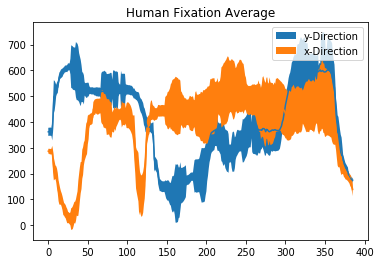

In [5]:
mean   = np.nanmean(y, axis=-1)
median = np.nanmedian(y, axis=-1)
std    = np.nanstd(y, axis=-1)

t = np.arange(len(mean.T))

plt.plot(t, median.T)
plt.fill_between(t, median[0]-std[0], median[0] + std[0], label="y-Direction")
plt.fill_between(t, median[1]-std[1], median[1] + std[1], label="x-Direction")
plt.title("Human Fixation Average")
plt.legend()
plt.show()

### Baseline Saliency Maps

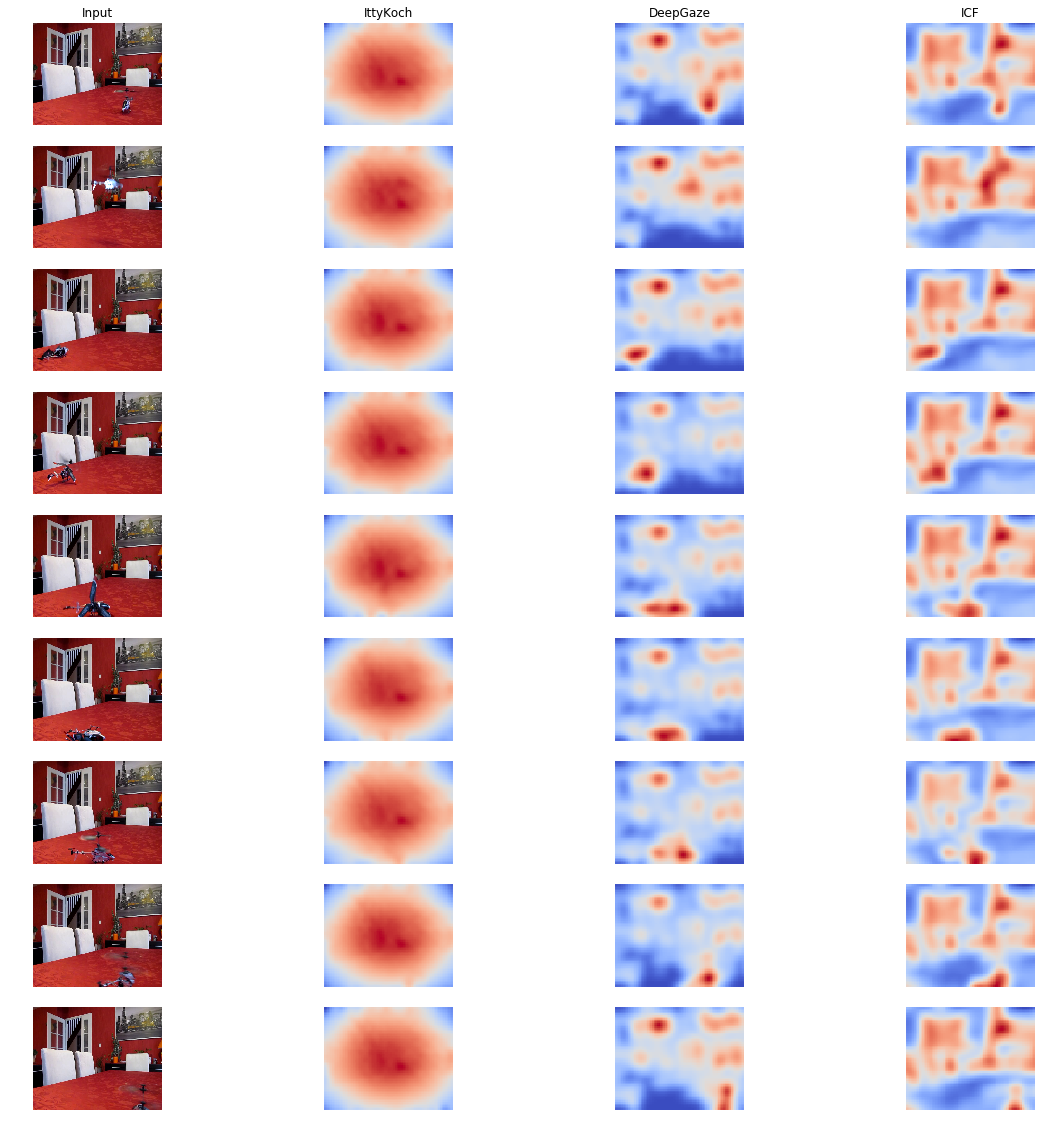

In [6]:
from saliency import  saliency

didc = slice(50+39,-41,30)
idc = slice(50+40,-40,30)

n_examples = len(X[idc])

fig, axes = plt.subplots(n_examples,4,figsize=(20,20))

titles = ['Input', 'IttyKoch', 'DeepGaze', 'ICF', 'combined']

for ax, imgs in zip(axes, zip(X[idc], S_ittykoch[idc], S_deep[idc], S_icf[idc])):
    for a, i in zip(ax,imgs):
        a.imshow(i, cmap="coolwarm")
        a.grid("off")
        a.axis("off")

for a, t in zip(axes[0], titles):
    a.set_title(t)
    
plt.show()

### Temporal Saliency Maps

We now compute temporal saliency maps $S^{\Delta,i}$ for all models $i$, according to

$$
S^{\Delta, i}_t = \exp(S_{t}) |\exp(S_{t}) - \exp(S_{t-1})|.
$$

This is followed by simple model averaging to obtain $S^\Delta:

$$
S^\Delta = \sum_i S^{\Delta, i}
$$

In [7]:
didc = slice(0,-1)
idc = slice(1,None)

diff = lambda x : np.exp(x[idc]) * abs(np.exp(x[idc])-np.exp(x[didc]))

dS_ittykoch = diff(S_ittykoch)
dS_icf      = diff(S_icf)
dS_deep     = diff(S_deep)

In [8]:
S_all = (sum(s for s in [dS_icf, dS_deep]))

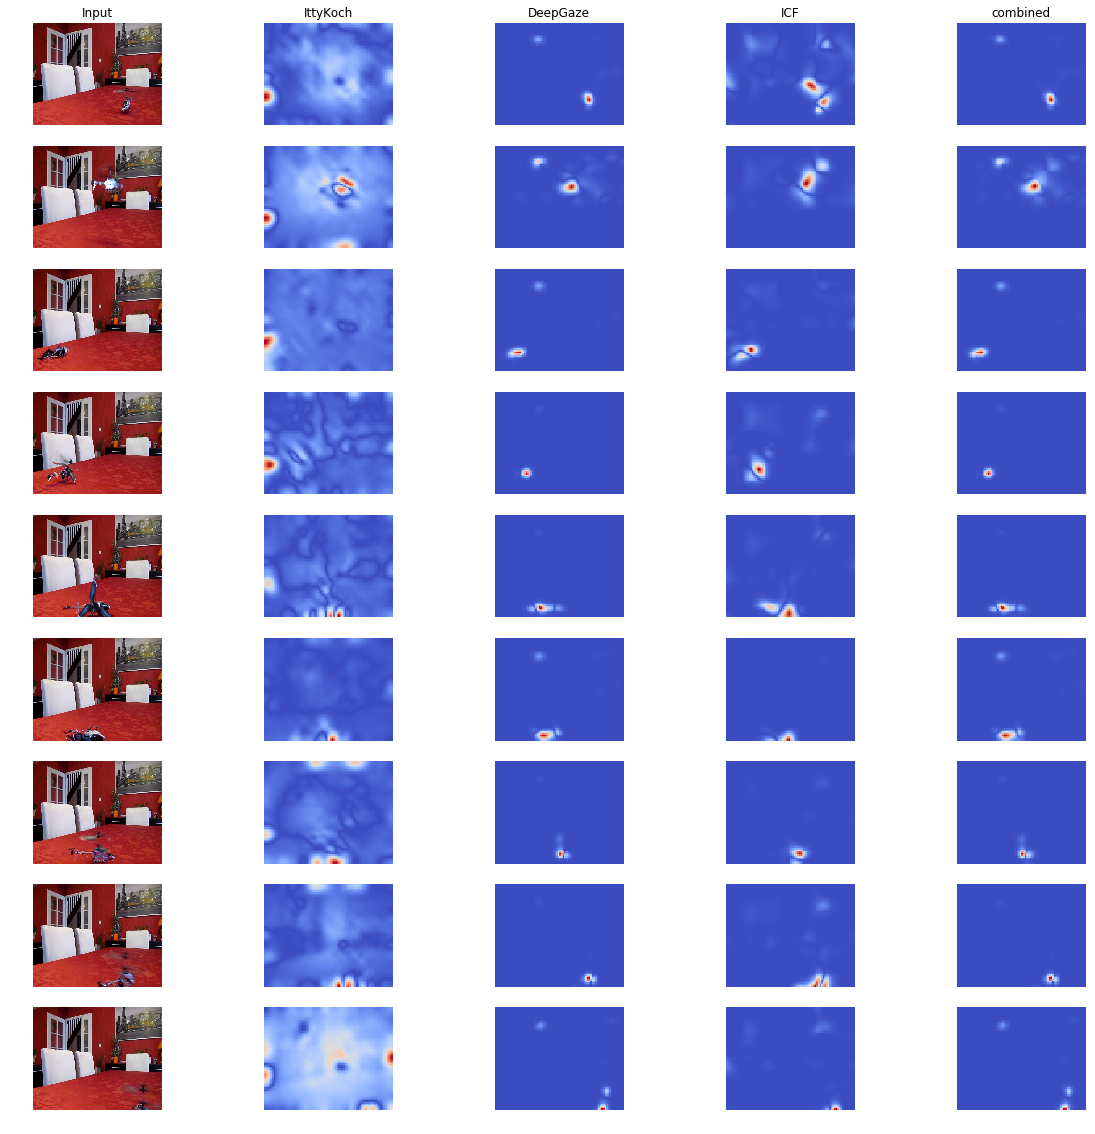

In [9]:
from saliency import  saliency

didc = slice(50+39,-41,30)
idc = slice(50+40,-40,30)

n_examples = len(X[idc])

fig, axes = plt.subplots(n_examples,5,figsize=(20,20))

titles = ['Input', 'IttyKoch', 'DeepGaze', 'ICF', 'combined']

for ax, imgs in zip(axes, zip(X[idc], dS_ittykoch[idc], dS_deep[idc], dS_icf[idc], S_all[idc])):
    for a, i in zip(ax,imgs):
        a.imshow(i, cmap="coolwarm")
        a.grid("off")
        a.axis("off")

for a, t in zip(axes[0], titles):
    a.set_title(t)
    
plt.savefig("report/fig/clip{}.pdf".format(ids[video_id]), bbox_inches="tight")

#### Test the current saliency model with the video

Use the code implemented in block 1 to test
the saliency response on the video. Be aware that due to the dynamics of the image we
cannot properly implement a fixation strategy like the inhibition of return developed in the
previous section.

In [10]:
S_all_log = np.log(1e-2+S_all)

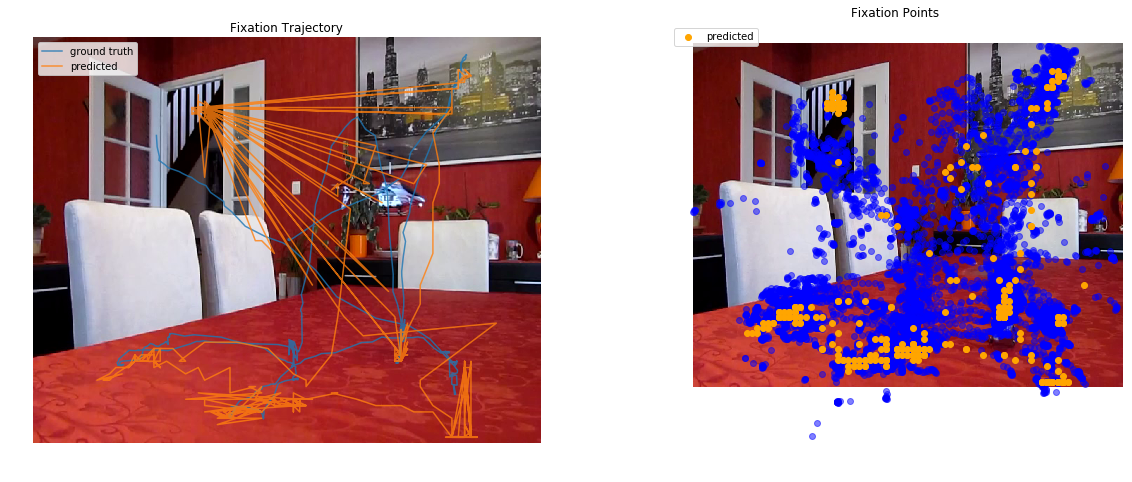

In [11]:
yy, xx = utils.argmax2d(S_all_log)
yy *= 9
xx *= 9

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))

ax1.imshow(X[0])
ax1.plot(median[0], median[1], alpha=.8, label="ground truth")
ax1.plot(xx,yy, alpha=.8, label="predicted")
ax1.legend()
ax1.axis("off")
ax1.set_title("Fixation Trajectory")

t = np.arange(y.shape[1])
ax2.imshow(X[100])
for i in range(y.shape[-1]):
    ax2.scatter(y[0,:,i], y[1,:,i], c="blue", alpha=.5)
ax2.scatter(xx,yy,color="orange", label="predicted")
ax2.set_title("Fixation Points")
ax2.legend()
ax2.axis("off")

plt.show()

### Evaluation

we will use two objective measures to evaluate the performance of the model:
the mean squared error from the average human fixation trajectory and NSS.

#### Median squared error

Given the human gaze fixation data median, $\mu' = (i, j)$ in
pixels coordinates, and the maximum salient response $\hat{\mu}$ from the model we
compute the total error of all frames $N$ as:

$$
\text{MSE}(\hat{\mu}, \mu') = \frac{1}{N} \sum_{i = 1}^N (\hat{\mu}_i - \mu'_i)^2
$$


#### NSS

Given a binary map of fixation locations F (human data) and the saliency map S
(response from the model), the NSS measure is computed as:

$$
\text{NSS}(S,F) = \frac{1}{N} \sum_{i = 1}^N \overline{S}_i \times F_i
$$

Where $N = \sum_i F_i$ is the total number of fixated pixels and $\overline{S} = \frac{S - \mu(S)}{\sigma(S)}$ is the normalized saliency map.
A value of 0 means means that it is chance (i.e., random), positive values shows correspondence and
negative values anti-correspondence.

/home/stes/sciebo/Privat/uni/msc/msne/semester_3/nise/saliency/saliency/utils.py:53: RuntimeWarning: Mean of empty slice
  nss_score = np.nanmean(nss_score, axis=1)


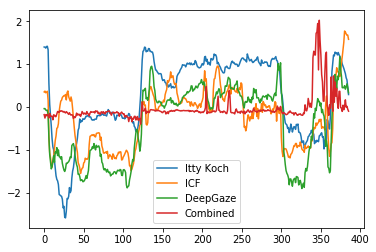

In [12]:
for s, t in zip([S_ittykoch, S_icf, S_deep, S_all], ["Itty Koch", "ICF", "DeepGaze", "Combined"]):

    nss = utils.nss(s,y/9,normalized=False)[1]
    plt.plot(nss,label=t)
    plt.legend()
plt.show()

In [13]:
from saliency import utils

names  = ['IttyKoch-BAS', 'DeepGaze-BAS', 'ICF-BAS', 'IttyKoch-DIFF',
          'DeepGaze-DIFF', 'ICF-DIFF', 'combined-DIFF']
output = [S_ittykoch, S_deep, S_icf, dS_ittykoch, dS_deep, dS_icf]


print("Clip {}".format(ids[video_id]))

results = {}

for name, S in zip(names, output):

    if len(S) < y.shape[1]:
        S = np.concatenate([S[0:],S_all[0:1]], axis=0)

    mse,_ = utils.mse(S, y/9, per_frame=True)
    nss,_ = utils.nss(S, y/9, normalized=False, per_frame=True)
    nssl,_ = utils.nss(np.log(S-S.min() + 1e-2), y/9, normalized=False, per_frame=True)

    print("{} \t MSE : {:10.2f}, \t NSS : {:.2f} \t NSS log : {:.2f}".format(name, mse, nss, nssl))
    
    
    yy, xx = utils.argmax2d(S)
    results['{}_x'.format(name)] = xx
    results['{}_y'.format(name)] = yy

Clip 6
IttyKoch-BAS 	 MSE :     508.69, 	 NSS : 0.24 	 NSS log : 0.18


/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/stes/sciebo/Privat/uni/msc/msne/semester_3/nise/saliency/saliency/utils.py:53: RuntimeWarning: Mean of empty slice
  nss_score = np.nanmean(nss_score, axis=1)


DeepGaze-BAS 	 MSE :     839.29, 	 NSS : -0.40 	 NSS log : -0.47
ICF-BAS 	 MSE :     849.14, 	 NSS : -0.24 	 NSS log : -0.22
IttyKoch-DIFF 	 MSE :    1982.02, 	 NSS : 0.04 	 NSS log : 0.03
DeepGaze-DIFF 	 MSE :     670.41, 	 NSS : -0.05 	 NSS log : -0.05
ICF-DIFF 	 MSE :     729.68, 	 NSS : 0.03 	 NSS log : 0.03


In [15]:
df = pd.DataFrame(data=results, index=np.arange(len(X)))
df.to_csv(fname_save)